In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt

In [2]:
#for replicability purposes
tf.random.set_seed(91195003)
np.random.seed(91195003)

#for an easy reset backend session state
tf.keras.backend.clear_session()

In [3]:
#load dataset
def load_dataset(path):
  return pd.read_csv(path)

In [4]:
#split data into training and validation sets
def split_data(training, perc=10):
  train_idx = np.arange(0,int(len(training)*(100-perc)/100))
  val_idx = np.arange(int(len(training)* (100-perc)/100+1),len(training))
  return train_idx, val_idx


In [5]:
#preparing the data for the LSTM
def prepare_data(df):
  df_aux = df.drop(columns=['nr_ruas_afetadas', 'comprimento_fila_metros', 'demora_fila_segundos'], inplace=False)
  df_aux["data"] = pd.to_datetime(df_aux["data"])
  df_aux = df_aux.sort_values('data')
  df_aux = df_aux.set_index('data')
  return df_aux


In [6]:
def data_normalization(df, norm_range=(-1, 1)):
    #[-1, 1] for LSTM due to the internal use of tanh by the memory cell
    scaler = MinMaxScaler(feature_range=norm_range)
    #df[['cases']] = scaler.fit_transform(df[['cases']])
    # df[['nr_ruas_afetadas']] = scaler.fit_transform(df[['nr_ruas_afetadas']])
    df[['Nr_acidentes']] = scaler.fit_transform(df[['Nr_acidentes']])
    # df[['comprimento_fila_metros']] = scaler.fit_transform(df[['comprimento_fila_metros']])
    # df[['demora_fila_segundos']] = scaler.fit_transform(df[['demora_fila_segundos']])

    return scaler

In [7]:
#plot learning curve
def plot_learning_curves(history, epochs):
  #accuracies and losses
  #dict_keys(['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse'])
  loss=history.history['loss']
  val_loss=history.history['val_loss']
  epochs_range = range(epochs)
  #creating figure
  plt.figure(figsize=(8,8))
  plt.subplot(1,2,2)
  plt.plot(epochs_range,loss,label='Training Loss')
  plt.plot(epochs_range,val_loss,label='Validation Loss')
  plt.legend(loc='upper right')
  plt.title('Training/Validation Loss')
  plt.show()


In [8]:
#Plot time series data
def plot_confirmed_cases(data):
        plt.figure(figsize=(8,6))
        plt.plot(range(len(data)), data)
        plt.title('Dataset Features')
        plt.ylabel('Valores')
        plt.xlabel('Semanas')
        plt.show()

In [9]:
#Preparing the dataset for the CNN
def to_supervised(df, timesteps):
  data = df.values
  X,y = list(), list()
  #iterate over the training set to create X and y
  dataset_size = len(data)
  for curr_pos in range(dataset_size):
    #end of the input sequence is the current position + the number of the timesteps of the input sequence
    input_index = curr_pos + timesteps
    #end of the labels corresponds to the end of the input sequence + 1
    label_index = input_index + 1
    #if we have enough data for this sequence
    if label_index < dataset_size:
      X.append(data[curr_pos:input_index,:])
      y.append(data[input_index:label_index,0])
        #using np.flot32 for GPU performance
  return np.array(X).astype('float32'), np.array(y).astype('float32')

In [10]:
#Building the model
def rmse(y_true, y_pred):
  return tf.keras.backend.sqrt(tf.keras.backend.mean(tf.keras.backend.square(y_pred - y_true)))


In [11]:
def build_model(timesteps, features, filters= 16, kernel_size=5, pool_size =2 ):
  #using the functional API
  inputs = tf.keras.layers.Input(shape=(timesteps, features))
  #microarchitecture
  x = tf.keras.layers.Conv1D(filters=filters, kernel_size = kernel_size, activation='relu', data_format = 'channels_last')(inputs)
  x = tf.keras.layers.AveragePooling1D(pool_size = pool_size, data_format = 'channels_first')(x)
  #last layers
  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(filters)(x)
  outputs = tf.keras.layers.Dense(1)(x)
  #the model
  cnnModel = tf.keras.Model(inputs=inputs, outputs=outputs, name='cnn_model')
  tf.keras.utils.plot_model(cnnModel,'cnnmodel.png', show_shapes=True)
  return cnnModel

In [12]:
def compile_and_fit(model, epochs, batch_size):
  #compile
  model.compile(loss=rmse, optimizer = tf.keras.optimizers.Adam(), metrics = ['mae',rmse])
  #fit
  hist_list = list()
  loss_list = list()
  #Time Series Cross Validator
  tscv = TimeSeriesSplit(n_splits=cv_splits)
  for train_index, test_index in tscv.split(X):
    train_idx, val_idx = split_data(train_index, perc=10) #further split into training and validation sets
    #build data
    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val = X[val_idx], y[val_idx]
    X_test, y_test = X[test_index], y[test_index]
    history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=epochs, batch_size=batch_size,shuffle=False)
    metrics = model.evaluate(X_test, y_test)

    plot_learning_curves(history, epochs)
    hist_list.append(history)

  return model, hist_list

In [13]:
def forecast(model, df, timesteps, multisteps, scaler):
  input_seq = np.array(df[-timesteps:].values) #getting the last sequence of known value
  inp = input_seq
  forecasts = list()
  print(inp)
  #multistep tells us how many iterations we want to perform
  #i. e. how many days we want to predict
  for step in range(1, multisteps+1):
    #implement
    inp = inp.reshape(1, timesteps, n_variate)
    pred = model.predict(inp)
    yhat_inversed = scaler.inverse_transform(pred)
    forecasts.append(yhat_inversed)
    # prepare new input to forecast the next day
    list_pred = [pred[0][0]]
    print('list_yhat:')
    print(list_pred)
    inp= np.append(inp[0],[[pred[0][0]]],axis=0) #adiciona previsão recente ao input
    inp = inp[-timesteps:]#vai ao input buscar os ultimos timesteps registados
    # print(step)
    print(step)
            
  return forecasts

In [14]:
def plot_forecast(data, forecasts):
        plt.figure(figsize=(14,6))
        plt.plot(range(len(data)),data["Nr_acidentes"], color='green', label='Confirmed')
        
        fi=[]
        for f in forecasts:
          fi.append(f[0][0])
          print('Previsão:' + str(f))
        print(fi)
        
        plt.plot(range(len(data)-1,len(data)+len(fi)-1), fi, color='red', label='Forecasts')
    
        plt.title('Nr de Acidentes em Braga')
        plt.ylabel('Value')
        plt.xlabel('Days')
        plt.legend()
        plt.show()

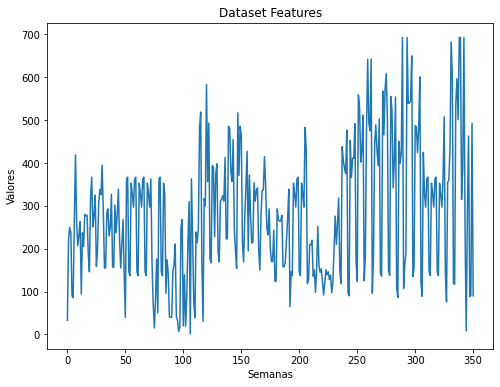

Epoch 1/10
16/16 [==============================] - 1s 32ms/step - loss: 0.3056 - mae: 0.2651 - rmse: 0.3057 - val_loss: 0.5620 - val_mae: 0.5347 - val_rmse: 0.5449
Epoch 2/10
16/16 [==============================] - 0s 3ms/step - loss: 0.2420 - mae: 0.2090 - rmse: 0.2422 - val_loss: 0.4731 - val_mae: 0.4426 - val_rmse: 0.4547
Epoch 3/10
16/16 [==============================] - 0s 3ms/step - loss: 0.2263 - mae: 0.1918 - rmse: 0.2264 - val_loss: 0.4594 - val_mae: 0.4302 - val_rmse: 0.4424
Epoch 4/10
16/16 [==============================] - 0s 3ms/step - loss: 0.2182 - mae: 0.1842 - rmse: 0.2184 - val_loss: 0.4717 - val_mae: 0.4443 - val_rmse: 0.4563
Epoch 5/10
16/16 [==============================] - 0s 3ms/step - loss: 0.2107 - mae: 0.1771 - rmse: 0.2108 - val_loss: 0.4776 - val_mae: 0.4513 - val_rmse: 0.4634
Epoch 6/10
16/16 [==============================] - 0s 3ms/step - loss: 0.2053 - mae: 0.1740 - rmse: 0.2055 - val_loss: 0.4786 - val_mae: 0.4526 - val_rmse: 0.4649
Epoch 7/10
16/1

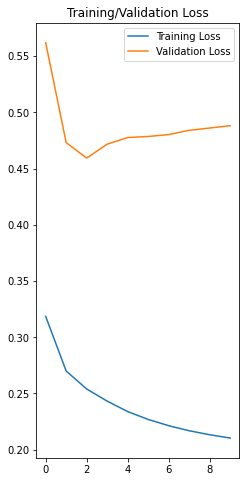

Epoch 1/10
31/31 [==============================] - 0s 4ms/step - loss: 0.2907 - mae: 0.2498 - rmse: 0.2907 - val_loss: 0.2087 - val_mae: 0.1845 - val_rmse: 0.2230
Epoch 2/10
31/31 [==============================] - 0s 3ms/step - loss: 0.2810 - mae: 0.2383 - rmse: 0.2810 - val_loss: 0.2059 - val_mae: 0.1793 - val_rmse: 0.2193
Epoch 3/10
31/31 [==============================] - 0s 3ms/step - loss: 0.2731 - mae: 0.2307 - rmse: 0.2731 - val_loss: 0.2053 - val_mae: 0.1782 - val_rmse: 0.2168
Epoch 4/10
31/31 [==============================] - 0s 3ms/step - loss: 0.2664 - mae: 0.2235 - rmse: 0.2664 - val_loss: 0.2052 - val_mae: 0.1770 - val_rmse: 0.2160
Epoch 5/10
31/31 [==============================] - 0s 3ms/step - loss: 0.2615 - mae: 0.2182 - rmse: 0.2615 - val_loss: 0.2054 - val_mae: 0.1763 - val_rmse: 0.2158
Epoch 6/10
31/31 [==============================] - 0s 3ms/step - loss: 0.2574 - mae: 0.2139 - rmse: 0.2574 - val_loss: 0.2061 - val_mae: 0.1757 - val_rmse: 0.2165
Epoch 7/10
31/31

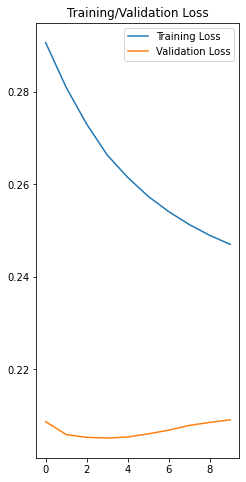

Epoch 1/10
47/47 [==============================] - 0s 5ms/step - loss: 0.2345 - mae: 0.1960 - rmse: 0.2374 - val_loss: 0.3607 - val_mae: 0.3151 - val_rmse: 0.3607
Epoch 2/10
47/47 [==============================] - 0s 2ms/step - loss: 0.2306 - mae: 0.1933 - rmse: 0.2336 - val_loss: 0.3562 - val_mae: 0.3107 - val_rmse: 0.3562
Epoch 3/10
47/47 [==============================] - 0s 2ms/step - loss: 0.2287 - mae: 0.1915 - rmse: 0.2317 - val_loss: 0.3523 - val_mae: 0.3072 - val_rmse: 0.3523
Epoch 4/10
47/47 [==============================] - 0s 2ms/step - loss: 0.2270 - mae: 0.1900 - rmse: 0.2300 - val_loss: 0.3495 - val_mae: 0.3046 - val_rmse: 0.3495
Epoch 5/10
47/47 [==============================] - 0s 2ms/step - loss: 0.2254 - mae: 0.1885 - rmse: 0.2285 - val_loss: 0.3468 - val_mae: 0.3007 - val_rmse: 0.3468
Epoch 6/10
47/47 [==============================] - 0s 2ms/step - loss: 0.2242 - mae: 0.1874 - rmse: 0.2273 - val_loss: 0.3439 - val_mae: 0.2977 - val_rmse: 0.3439
Epoch 7/10
47/47

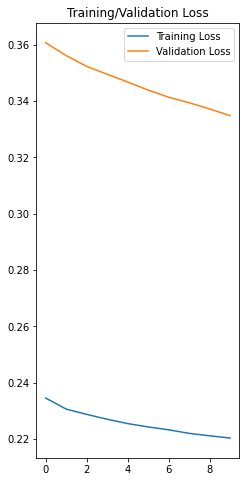

[[-0.97976879]
 [-0.1734104 ]
 [ 0.33526012]
 [-0.74855491]
 [-0.73699422]
 [ 0.42196532]
 [-0.74277457]]
list_yhat:
[-0.77928174]
1
list_yhat:
[-0.15592498]
2
list_yhat:
[-0.16619973]
3
list_yhat:
[-0.7293182]
4
list_yhat:
[-0.21559785]
5
list_yhat:
[-0.049520347]
6
list_yhat:
[-0.60758257]
7
list_yhat:
[-0.60897255]
8
list_yhat:
[-0.12932453]
9
list_yhat:
[-0.33245078]
10
list_yhat:
[-0.43366286]
11
list_yhat:
[-0.13765097]
12
list_yhat:
[-0.19041097]
13
list_yhat:
[-0.5836647]
14
list_yhat:
[-0.40104556]
15
Previsão:[[77.368515]]
Previsão:[[293.04996]]
Previsão:[[289.49487]]
Previsão:[[94.6559]]
Previsão:[[272.40314]]
Previsão:[[329.86597]]
Previsão:[[136.77643]]
Previsão:[[136.2955]]
Previsão:[[302.25372]]
Previsão:[[231.97205]]
Previsão:[[196.95265]]
Previsão:[[299.37277]]
Previsão:[[281.1178]]
Previsão:[[145.052]]
Previsão:[[208.23824]]
[77.368515, 293.04996, 289.49487, 94.6559, 272.40314, 329.86597, 136.77643, 136.2955, 302.25372, 231.97205, 196.95265, 299.37277, 281.1178, 145.0

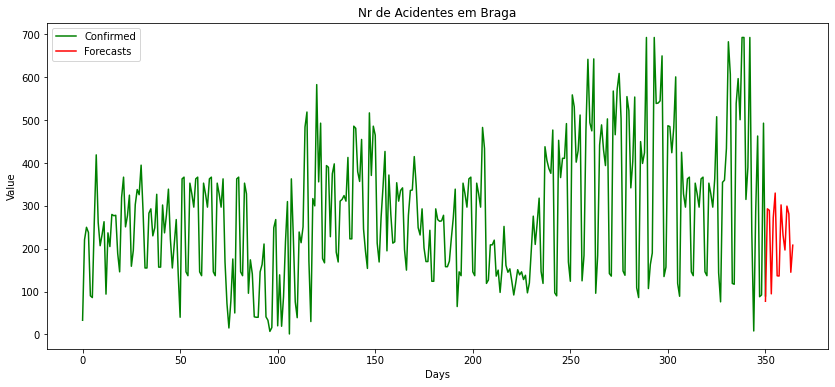

[array([[77.368515]], dtype=float32), array([[293.04996]], dtype=float32), array([[289.49487]], dtype=float32), array([[94.6559]], dtype=float32), array([[272.40314]], dtype=float32), array([[329.86597]], dtype=float32), array([[136.77643]], dtype=float32), array([[136.2955]], dtype=float32), array([[302.25372]], dtype=float32), array([[231.97205]], dtype=float32), array([[196.95265]], dtype=float32), array([[299.37277]], dtype=float32), array([[281.1178]], dtype=float32), array([[145.052]], dtype=float32), array([[208.23824]], dtype=float32)]
Epoch 1/50
16/16 [==============================] - 1s 12ms/step - loss: 0.2903 - mae: 0.2394 - rmse: 0.2903 - val_loss: 0.3488 - val_mae: 0.3061 - val_rmse: 0.3344
Epoch 2/50
16/16 [==============================] - 0s 4ms/step - loss: 0.2653 - mae: 0.2205 - rmse: 0.2653 - val_loss: 0.3546 - val_mae: 0.3100 - val_rmse: 0.3399
Epoch 3/50
16/16 [==============================] - 0s 3ms/step - loss: 0.2545 - mae: 0.2117 - rmse: 0.2545 - val_loss: 0

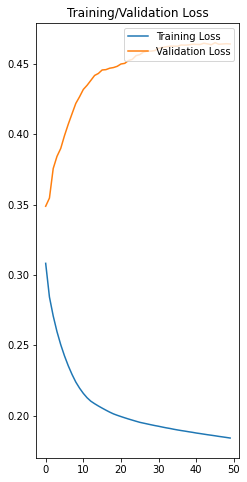

Epoch 1/50
31/31 [==============================] - 0s 4ms/step - loss: 0.2861 - mae: 0.2246 - rmse: 0.2861 - val_loss: 0.1985 - val_mae: 0.1736 - val_rmse: 0.2039
Epoch 2/50
31/31 [==============================] - 0s 3ms/step - loss: 0.2784 - mae: 0.2189 - rmse: 0.2784 - val_loss: 0.1947 - val_mae: 0.1705 - val_rmse: 0.1992
Epoch 3/50
31/31 [==============================] - 0s 2ms/step - loss: 0.2696 - mae: 0.2142 - rmse: 0.2696 - val_loss: 0.1899 - val_mae: 0.1646 - val_rmse: 0.1944
Epoch 4/50
31/31 [==============================] - 0s 3ms/step - loss: 0.2634 - mae: 0.2108 - rmse: 0.2634 - val_loss: 0.1872 - val_mae: 0.1611 - val_rmse: 0.1913
Epoch 5/50
31/31 [==============================] - 0s 3ms/step - loss: 0.2581 - mae: 0.2082 - rmse: 0.2581 - val_loss: 0.1837 - val_mae: 0.1575 - val_rmse: 0.1877
Epoch 6/50
31/31 [==============================] - 0s 3ms/step - loss: 0.2534 - mae: 0.2053 - rmse: 0.2534 - val_loss: 0.1829 - val_mae: 0.1570 - val_rmse: 0.1871
Epoch 7/50
31/31

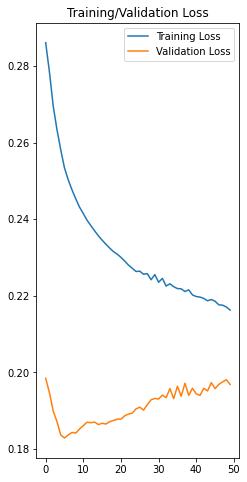

Epoch 1/50
47/47 [==============================] - 0s 5ms/step - loss: 0.2161 - mae: 0.1813 - rmse: 0.2200 - val_loss: 0.2999 - val_mae: 0.2473 - val_rmse: 0.2999
Epoch 2/50
47/47 [==============================] - 0s 2ms/step - loss: 0.2145 - mae: 0.1790 - rmse: 0.2184 - val_loss: 0.3028 - val_mae: 0.2448 - val_rmse: 0.3028
Epoch 3/50
47/47 [==============================] - 0s 2ms/step - loss: 0.2139 - mae: 0.1789 - rmse: 0.2179 - val_loss: 0.3065 - val_mae: 0.2499 - val_rmse: 0.3065
Epoch 4/50
47/47 [==============================] - 0s 2ms/step - loss: 0.2131 - mae: 0.1782 - rmse: 0.2172 - val_loss: 0.3064 - val_mae: 0.2467 - val_rmse: 0.3064
Epoch 5/50
47/47 [==============================] - 0s 2ms/step - loss: 0.2129 - mae: 0.1783 - rmse: 0.2169 - val_loss: 0.3068 - val_mae: 0.2494 - val_rmse: 0.3068
Epoch 6/50
47/47 [==============================] - 0s 2ms/step - loss: 0.2122 - mae: 0.1776 - rmse: 0.2162 - val_loss: 0.3054 - val_mae: 0.2474 - val_rmse: 0.3054
Epoch 7/50
47/47

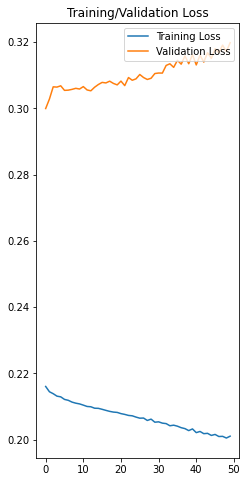

[[-0.97976879]
 [-0.1734104 ]
 [ 0.33526012]
 [-0.74855491]
 [-0.73699422]
 [ 0.42196532]
 [-0.74277457]]
list_yhat:
[-0.36933994]
1
list_yhat:
[0.00077334273]
2
list_yhat:
[0.034756746]
3
list_yhat:
[-0.5078209]
4
list_yhat:
[-0.12794669]
5
list_yhat:
[-0.07285891]
6
list_yhat:
[-0.4209297]
7
list_yhat:
[-0.3898178]
8
list_yhat:
[-0.12974836]
9
list_yhat:
[-0.22959974]
10
list_yhat:
[-0.28981405]
11
list_yhat:
[-0.19629946]
12
list_yhat:
[-0.19058327]
13
list_yhat:
[-0.35274285]
14
list_yhat:
[-0.33297732]
15
Previsão:[[219.20837]]
Previsão:[[347.26758]]
Previsão:[[359.02582]]
Previsão:[[171.29396]]
Previsão:[[302.73044]]
Previsão:[[321.7908]]
Previsão:[[201.35834]]
Previsão:[[212.12305]]
Previsão:[[302.1071]]
Previsão:[[267.5585]]
Previsão:[[246.72433]]
Previsão:[[279.08038]]
Previsão:[[281.05817]]
Previsão:[[224.95097]]
Previsão:[[231.78986]]
[219.20837, 347.26758, 359.02582, 171.29396, 302.73044, 321.7908, 201.35834, 212.12305, 302.1071, 267.5585, 246.72433, 279.08038, 281.05817, 2

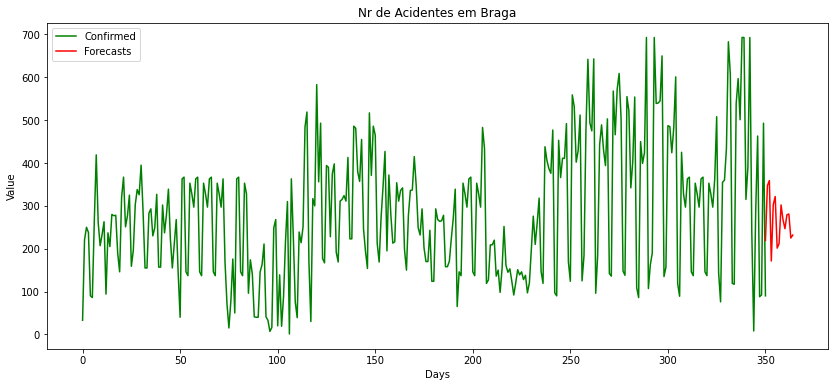

[array([[219.20837]], dtype=float32), array([[347.26758]], dtype=float32), array([[359.02582]], dtype=float32), array([[171.29396]], dtype=float32), array([[302.73044]], dtype=float32), array([[321.7908]], dtype=float32), array([[201.35834]], dtype=float32), array([[212.12305]], dtype=float32), array([[302.1071]], dtype=float32), array([[267.5585]], dtype=float32), array([[246.72433]], dtype=float32), array([[279.08038]], dtype=float32), array([[281.05817]], dtype=float32), array([[224.95097]], dtype=float32), array([[231.78986]], dtype=float32)]
Epoch 1/100
16/16 [==============================] - 1s 13ms/step - loss: 0.3649 - mae: 0.3212 - rmse: 0.3649 - val_loss: 0.5767 - val_mae: 0.5500 - val_rmse: 0.5640
Epoch 2/100
16/16 [==============================] - 0s 4ms/step - loss: 0.2632 - mae: 0.2236 - rmse: 0.2633 - val_loss: 0.4129 - val_mae: 0.3713 - val_rmse: 0.3980
Epoch 3/100
16/16 [==============================] - 0s 3ms/step - loss: 0.2430 - mae: 0.2009 - rmse: 0.2431 - val_l

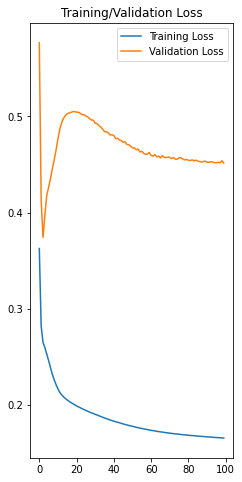

Epoch 1/100
31/31 [==============================] - 0s 4ms/step - loss: 0.2703 - mae: 0.2235 - rmse: 0.2703 - val_loss: 0.2137 - val_mae: 0.1811 - val_rmse: 0.2203
Epoch 2/100
31/31 [==============================] - 0s 2ms/step - loss: 0.2619 - mae: 0.2160 - rmse: 0.2619 - val_loss: 0.2079 - val_mae: 0.1775 - val_rmse: 0.2110
Epoch 3/100
31/31 [==============================] - 0s 2ms/step - loss: 0.2547 - mae: 0.2101 - rmse: 0.2547 - val_loss: 0.2060 - val_mae: 0.1727 - val_rmse: 0.2099
Epoch 4/100
31/31 [==============================] - 0s 3ms/step - loss: 0.2479 - mae: 0.2052 - rmse: 0.2479 - val_loss: 0.2055 - val_mae: 0.1735 - val_rmse: 0.2100
Epoch 5/100
31/31 [==============================] - 0s 2ms/step - loss: 0.2443 - mae: 0.2027 - rmse: 0.2443 - val_loss: 0.2067 - val_mae: 0.1746 - val_rmse: 0.2116
Epoch 6/100
31/31 [==============================] - 0s 3ms/step - loss: 0.2419 - mae: 0.2009 - rmse: 0.2419 - val_loss: 0.2075 - val_mae: 0.1757 - val_rmse: 0.2122
Epoch 7/10

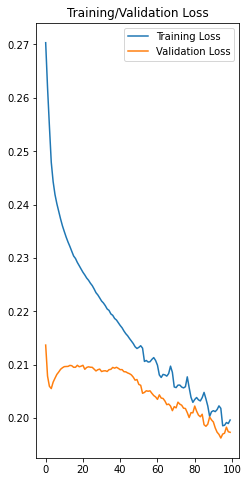

Epoch 1/100
47/47 [==============================] - 0s 5ms/step - loss: 0.2039 - mae: 0.1705 - rmse: 0.2069 - val_loss: 0.2977 - val_mae: 0.2461 - val_rmse: 0.2977
Epoch 2/100
47/47 [==============================] - 0s 2ms/step - loss: 0.2013 - mae: 0.1689 - rmse: 0.2042 - val_loss: 0.2971 - val_mae: 0.2456 - val_rmse: 0.2971
Epoch 3/100
47/47 [==============================] - 0s 2ms/step - loss: 0.1997 - mae: 0.1671 - rmse: 0.2027 - val_loss: 0.2965 - val_mae: 0.2451 - val_rmse: 0.2965
Epoch 4/100
47/47 [==============================] - 0s 2ms/step - loss: 0.1991 - mae: 0.1665 - rmse: 0.2021 - val_loss: 0.2959 - val_mae: 0.2447 - val_rmse: 0.2959
Epoch 5/100
47/47 [==============================] - 0s 2ms/step - loss: 0.1986 - mae: 0.1661 - rmse: 0.2015 - val_loss: 0.2950 - val_mae: 0.2432 - val_rmse: 0.2950
Epoch 6/100
47/47 [==============================] - 0s 2ms/step - loss: 0.1989 - mae: 0.1664 - rmse: 0.2018 - val_loss: 0.2955 - val_mae: 0.2463 - val_rmse: 0.2955
Epoch 7/10

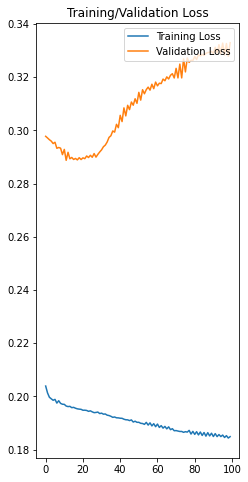

[[-0.97976879]
 [-0.1734104 ]
 [ 0.33526012]
 [-0.74855491]
 [-0.73699422]
 [ 0.42196532]
 [-0.74277457]]
list_yhat:
[0.0035744235]
1
list_yhat:
[0.33400568]
2
list_yhat:
[0.1340133]
3
list_yhat:
[-0.12833866]
4
list_yhat:
[0.5127491]
5
list_yhat:
[0.19116507]
6
list_yhat:
[-0.46008605]
7
list_yhat:
[-0.23084985]
8
list_yhat:
[0.42390382]
9
list_yhat:
[0.24311867]
10
list_yhat:
[0.10689813]
11
list_yhat:
[0.21588889]
12
list_yhat:
[0.27255082]
13
list_yhat:
[-0.26412615]
14
list_yhat:
[-0.26502526]
15
Previsão:[[348.23676]]
Previsão:[[462.56595]]
Previsão:[[393.36862]]
Previsão:[[302.59482]]
Previsão:[[524.4112]]
Previsão:[[413.1431]]
Previsão:[[187.81023]]
Previsão:[[267.12595]]
Previsão:[[493.67075]]
Previsão:[[431.11908]]
Previsão:[[383.98676]]
Previsão:[[421.69757]]
Previsão:[[441.3026]]
Previsão:[[255.61237]]
Previsão:[[255.30125]]
[348.23676, 462.56595, 393.36862, 302.59482, 524.4112, 413.1431, 187.81023, 267.12595, 493.67075, 431.11908, 383.98676, 421.69757, 441.3026, 255.61237,

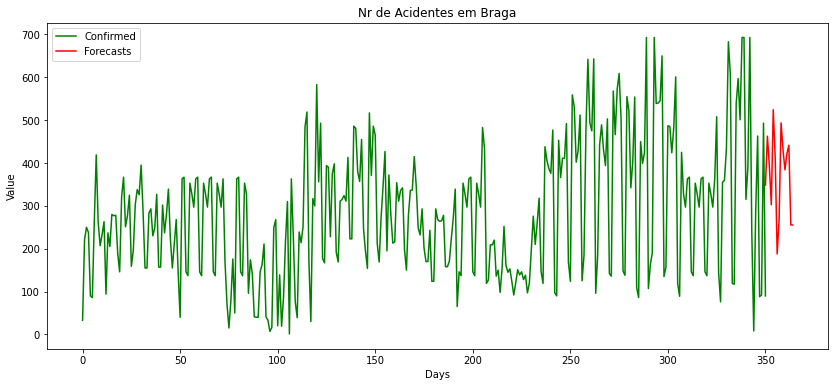

[array([[348.23676]], dtype=float32), array([[462.56595]], dtype=float32), array([[393.36862]], dtype=float32), array([[302.59482]], dtype=float32), array([[524.4112]], dtype=float32), array([[413.1431]], dtype=float32), array([[187.81023]], dtype=float32), array([[267.12595]], dtype=float32), array([[493.67075]], dtype=float32), array([[431.11908]], dtype=float32), array([[383.98676]], dtype=float32), array([[421.69757]], dtype=float32), array([[441.3026]], dtype=float32), array([[255.61237]], dtype=float32), array([[255.30125]], dtype=float32)]
Epoch 1/60
16/16 [==============================] - 1s 13ms/step - loss: 0.2626 - mae: 0.2051 - rmse: 0.2629 - val_loss: 0.3644 - val_mae: 0.3396 - val_rmse: 0.3322
Epoch 2/60
16/16 [==============================] - 0s 4ms/step - loss: 0.2274 - mae: 0.1977 - rmse: 0.2276 - val_loss: 0.3913 - val_mae: 0.3681 - val_rmse: 0.3598
Epoch 3/60
16/16 [==============================] - 0s 4ms/step - loss: 0.2082 - mae: 0.1764 - rmse: 0.2085 - val_loss

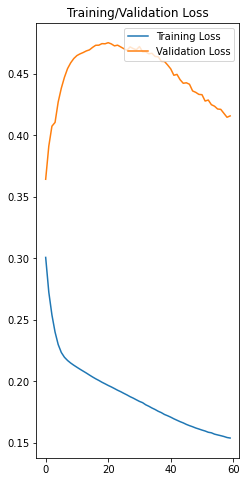

Epoch 1/60
31/31 [==============================] - 0s 4ms/step - loss: 0.2605 - mae: 0.2174 - rmse: 0.2593 - val_loss: 0.2183 - val_mae: 0.1900 - val_rmse: 0.2219
Epoch 2/60
31/31 [==============================] - 0s 2ms/step - loss: 0.2558 - mae: 0.2137 - rmse: 0.2547 - val_loss: 0.2142 - val_mae: 0.1858 - val_rmse: 0.2144
Epoch 3/60
31/31 [==============================] - 0s 3ms/step - loss: 0.2522 - mae: 0.2100 - rmse: 0.2511 - val_loss: 0.2110 - val_mae: 0.1828 - val_rmse: 0.2096
Epoch 4/60
31/31 [==============================] - 0s 2ms/step - loss: 0.2484 - mae: 0.2070 - rmse: 0.2473 - val_loss: 0.2070 - val_mae: 0.1786 - val_rmse: 0.2064
Epoch 5/60
31/31 [==============================] - 0s 2ms/step - loss: 0.2446 - mae: 0.2043 - rmse: 0.2435 - val_loss: 0.2039 - val_mae: 0.1747 - val_rmse: 0.2041
Epoch 6/60
31/31 [==============================] - 0s 2ms/step - loss: 0.2416 - mae: 0.2021 - rmse: 0.2404 - val_loss: 0.2019 - val_mae: 0.1720 - val_rmse: 0.2026
Epoch 7/60
31/31

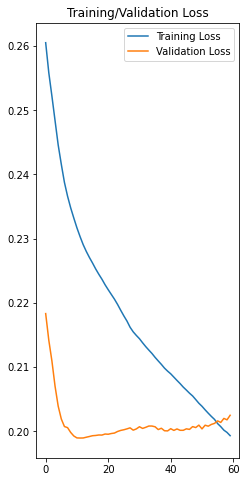

Epoch 1/60
47/47 [==============================] - 0s 5ms/step - loss: 0.2063 - mae: 0.1726 - rmse: 0.2068 - val_loss: 0.2908 - val_mae: 0.2390 - val_rmse: 0.2908
Epoch 2/60
47/47 [==============================] - 0s 2ms/step - loss: 0.2050 - mae: 0.1725 - rmse: 0.2048 - val_loss: 0.2910 - val_mae: 0.2415 - val_rmse: 0.2910
Epoch 3/60
47/47 [==============================] - 0s 2ms/step - loss: 0.2043 - mae: 0.1724 - rmse: 0.2038 - val_loss: 0.2891 - val_mae: 0.2412 - val_rmse: 0.2891
Epoch 4/60
47/47 [==============================] - 0s 2ms/step - loss: 0.2040 - mae: 0.1723 - rmse: 0.2032 - val_loss: 0.2900 - val_mae: 0.2424 - val_rmse: 0.2900
Epoch 5/60
47/47 [==============================] - 0s 2ms/step - loss: 0.2039 - mae: 0.1722 - rmse: 0.2029 - val_loss: 0.2921 - val_mae: 0.2447 - val_rmse: 0.2921
Epoch 6/60
47/47 [==============================] - 0s 2ms/step - loss: 0.2035 - mae: 0.1720 - rmse: 0.2025 - val_loss: 0.2923 - val_mae: 0.2452 - val_rmse: 0.2923
Epoch 7/60
47/47

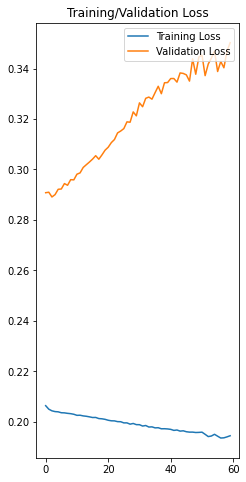

[[-0.31213873]
 [-0.97976879]
 [-0.1734104 ]
 [ 0.33526012]
 [-0.74855491]
 [-0.73699422]
 [ 0.42196532]
 [-0.74277457]]
list_yhat:
[-0.4025017]
1
list_yhat:
[-0.25451908]
2
list_yhat:
[-0.5902889]
3
list_yhat:
[-0.56378156]
4
list_yhat:
[-0.34964362]
5
list_yhat:
[-0.5992315]
6
list_yhat:
[-0.30288595]
7
list_yhat:
[-0.22075874]
8
list_yhat:
[-0.46344972]
9
list_yhat:
[-0.53802]
10
list_yhat:
[-0.38199797]
11
list_yhat:
[-0.3891451]
12
list_yhat:
[-0.46619874]
13
list_yhat:
[-0.32912433]
14
list_yhat:
[-0.39282426]
15
Previsão:[[207.7344]]
Previsão:[[258.9364]]
Previsão:[[142.76004]]
Previsão:[[151.93158]]
Previsão:[[226.02332]]
Previsão:[[139.66591]]
Previsão:[[242.20146]]
Previsão:[[270.61746]]
Previsão:[[186.6464]]
Previsão:[[160.84508]]
Previsão:[[214.8287]]
Previsão:[[212.3558]]
Previsão:[[185.69524]]
Previsão:[[233.12299]]
Previsão:[[211.08281]]
[207.7344, 258.9364, 142.76004, 151.93158, 226.02332, 139.66591, 242.20146, 270.61746, 186.6464, 160.84508, 214.8287, 212.3558, 185.695

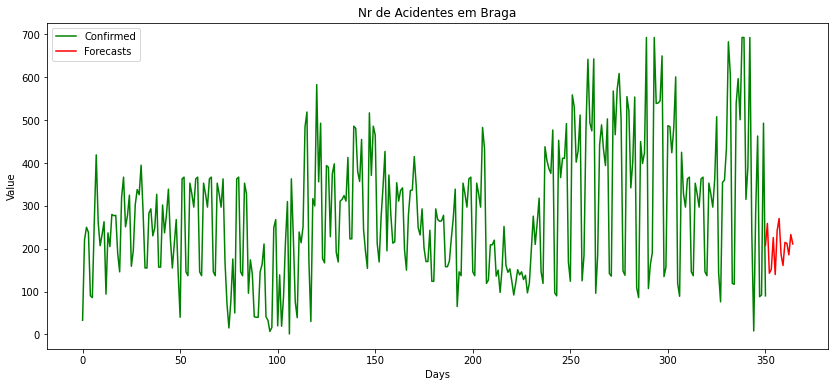

[array([[207.7344]], dtype=float32), array([[258.9364]], dtype=float32), array([[142.76004]], dtype=float32), array([[151.93158]], dtype=float32), array([[226.02332]], dtype=float32), array([[139.66591]], dtype=float32), array([[242.20146]], dtype=float32), array([[270.61746]], dtype=float32), array([[186.6464]], dtype=float32), array([[160.84508]], dtype=float32), array([[214.8287]], dtype=float32), array([[212.3558]], dtype=float32), array([[185.69524]], dtype=float32), array([[233.12299]], dtype=float32), array([[211.08281]], dtype=float32)]
Epoch 1/90
16/16 [==============================] - 1s 13ms/step - loss: 0.3781 - mae: 0.3312 - rmse: 0.3779 - val_loss: 0.5258 - val_mae: 0.4952 - val_rmse: 0.5106
Epoch 2/90
16/16 [==============================] - 0s 4ms/step - loss: 0.2285 - mae: 0.1901 - rmse: 0.2287 - val_loss: 0.3594 - val_mae: 0.3204 - val_rmse: 0.3433
Epoch 3/90
16/16 [==============================] - 0s 4ms/step - loss: 0.2095 - mae: 0.1869 - rmse: 0.2095 - val_loss: 

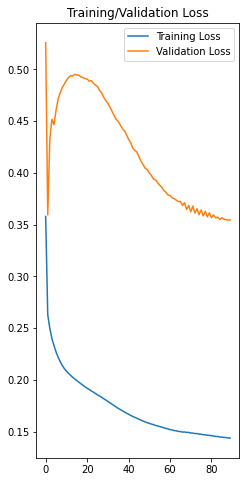

Epoch 1/90
31/31 [==============================] - 0s 4ms/step - loss: 0.2510 - mae: 0.2036 - rmse: 0.2500 - val_loss: 0.2056 - val_mae: 0.1793 - val_rmse: 0.2301
Epoch 2/90
31/31 [==============================] - 0s 3ms/step - loss: 0.2454 - mae: 0.2050 - rmse: 0.2444 - val_loss: 0.2016 - val_mae: 0.1769 - val_rmse: 0.2225
Epoch 3/90
31/31 [==============================] - 0s 2ms/step - loss: 0.2400 - mae: 0.2009 - rmse: 0.2390 - val_loss: 0.1984 - val_mae: 0.1755 - val_rmse: 0.2163
Epoch 4/90
31/31 [==============================] - 0s 3ms/step - loss: 0.2361 - mae: 0.1978 - rmse: 0.2351 - val_loss: 0.1968 - val_mae: 0.1741 - val_rmse: 0.2132
Epoch 5/90
31/31 [==============================] - 0s 2ms/step - loss: 0.2333 - mae: 0.1957 - rmse: 0.2323 - val_loss: 0.1959 - val_mae: 0.1734 - val_rmse: 0.2116
Epoch 6/90
31/31 [==============================] - 0s 3ms/step - loss: 0.2310 - mae: 0.1940 - rmse: 0.2300 - val_loss: 0.1958 - val_mae: 0.1730 - val_rmse: 0.2105
Epoch 7/90
31/31

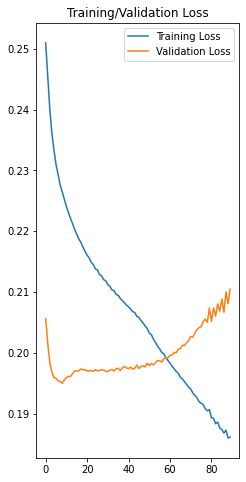

Epoch 1/90
47/47 [==============================] - 0s 5ms/step - loss: 0.1958 - mae: 0.1647 - rmse: 0.1970 - val_loss: 0.3031 - val_mae: 0.2371 - val_rmse: 0.3031
Epoch 2/90
47/47 [==============================] - 0s 2ms/step - loss: 0.1970 - mae: 0.1652 - rmse: 0.1978 - val_loss: 0.2996 - val_mae: 0.2376 - val_rmse: 0.2996
Epoch 3/90
47/47 [==============================] - 0s 2ms/step - loss: 0.1960 - mae: 0.1637 - rmse: 0.1966 - val_loss: 0.2980 - val_mae: 0.2368 - val_rmse: 0.2980
Epoch 4/90
47/47 [==============================] - 0s 2ms/step - loss: 0.1953 - mae: 0.1632 - rmse: 0.1957 - val_loss: 0.2955 - val_mae: 0.2350 - val_rmse: 0.2955
Epoch 5/90
47/47 [==============================] - 0s 2ms/step - loss: 0.1946 - mae: 0.1625 - rmse: 0.1946 - val_loss: 0.2965 - val_mae: 0.2359 - val_rmse: 0.2965
Epoch 6/90
47/47 [==============================] - 0s 2ms/step - loss: 0.1941 - mae: 0.1618 - rmse: 0.1940 - val_loss: 0.2963 - val_mae: 0.2361 - val_rmse: 0.2963
Epoch 7/90
47/47

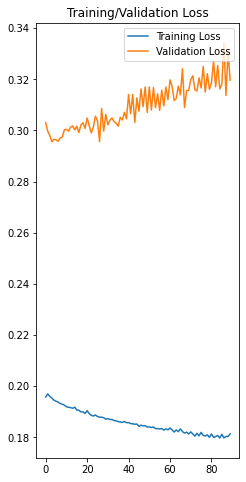

[[-0.31213873]
 [-0.97976879]
 [-0.1734104 ]
 [ 0.33526012]
 [-0.74855491]
 [-0.73699422]
 [ 0.42196532]
 [-0.74277457]]
list_yhat:
[-0.5032789]
1
list_yhat:
[-0.22471766]
2
list_yhat:
[-0.50796634]
3
list_yhat:
[-0.5120181]
4
list_yhat:
[-0.3738174]
5
list_yhat:
[-0.48432046]
6
list_yhat:
[-0.37492967]
7
list_yhat:
[-0.24911833]
8
list_yhat:
[-0.31810847]
9
list_yhat:
[-0.48258668]
10
list_yhat:
[-0.4661141]
11
list_yhat:
[-0.44105956]
12
list_yhat:
[-0.5436828]
13
list_yhat:
[-0.44765818]
14
list_yhat:
[-0.2566607]
15
Previsão:[[172.8655]]
Previsão:[[269.24768]]
Previsão:[[171.24365]]
Previsão:[[169.84174]]
Previsão:[[217.65918]]
Previsão:[[179.42513]]
Previsão:[[217.27434]]
Previsão:[[260.80505]]
Previsão:[[236.93448]]
Previsão:[[180.02501]]
Previsão:[[185.72452]]
Previsão:[[194.3934]]
Previsão:[[158.88574]]
Previsão:[[192.11028]]
Previsão:[[258.1954]]
[172.8655, 269.24768, 171.24365, 169.84174, 217.65918, 179.42513, 217.27434, 260.80505, 236.93448, 180.02501, 185.72452, 194.3934, 1

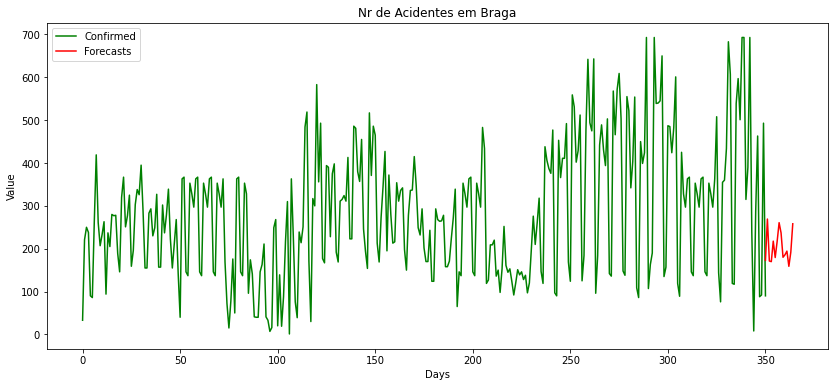

[array([[172.8655]], dtype=float32), array([[269.24768]], dtype=float32), array([[171.24365]], dtype=float32), array([[169.84174]], dtype=float32), array([[217.65918]], dtype=float32), array([[179.42513]], dtype=float32), array([[217.27434]], dtype=float32), array([[260.80505]], dtype=float32), array([[236.93448]], dtype=float32), array([[180.02501]], dtype=float32), array([[185.72452]], dtype=float32), array([[194.3934]], dtype=float32), array([[158.88574]], dtype=float32), array([[192.11028]], dtype=float32), array([[258.1954]], dtype=float32)]
Epoch 1/120
16/16 [==============================] - 1s 13ms/step - loss: 0.3382 - mae: 0.2929 - rmse: 0.3383 - val_loss: 0.4721 - val_mae: 0.4391 - val_rmse: 0.4438
Epoch 2/120
16/16 [==============================] - 0s 4ms/step - loss: 0.2090 - mae: 0.1775 - rmse: 0.2094 - val_loss: 0.3528 - val_mae: 0.3234 - val_rmse: 0.3245
Epoch 3/120
16/16 [==============================] - 0s 4ms/step - loss: 0.1924 - mae: 0.1709 - rmse: 0.1927 - val_l

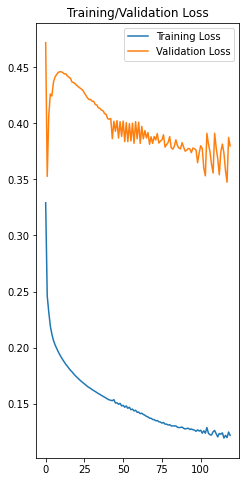

Epoch 1/120
31/31 [==============================] - 0s 4ms/step - loss: 0.2677 - mae: 0.2186 - rmse: 0.2666 - val_loss: 0.2339 - val_mae: 0.2062 - val_rmse: 0.2235
Epoch 2/120
31/31 [==============================] - 0s 3ms/step - loss: 0.2615 - mae: 0.2149 - rmse: 0.2603 - val_loss: 0.2286 - val_mae: 0.2035 - val_rmse: 0.2220
Epoch 3/120
31/31 [==============================] - 0s 2ms/step - loss: 0.2525 - mae: 0.2075 - rmse: 0.2514 - val_loss: 0.2260 - val_mae: 0.1999 - val_rmse: 0.2203
Epoch 4/120
31/31 [==============================] - 0s 2ms/step - loss: 0.2467 - mae: 0.2024 - rmse: 0.2456 - val_loss: 0.2239 - val_mae: 0.1973 - val_rmse: 0.2193
Epoch 5/120
31/31 [==============================] - 0s 2ms/step - loss: 0.2424 - mae: 0.1990 - rmse: 0.2413 - val_loss: 0.2220 - val_mae: 0.1954 - val_rmse: 0.2189
Epoch 6/120
31/31 [==============================] - 0s 2ms/step - loss: 0.2387 - mae: 0.1963 - rmse: 0.2376 - val_loss: 0.2202 - val_mae: 0.1929 - val_rmse: 0.2182
Epoch 7/12

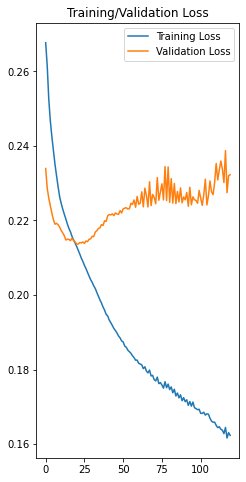

Epoch 1/120
47/47 [==============================] - 0s 5ms/step - loss: 0.1823 - mae: 0.1524 - rmse: 0.1814 - val_loss: 0.4591 - val_mae: 0.3743 - val_rmse: 0.4591
Epoch 2/120
47/47 [==============================] - 0s 2ms/step - loss: 0.1851 - mae: 0.1549 - rmse: 0.1837 - val_loss: 0.4645 - val_mae: 0.3836 - val_rmse: 0.4645
Epoch 3/120
47/47 [==============================] - 0s 2ms/step - loss: 0.1842 - mae: 0.1544 - rmse: 0.1822 - val_loss: 0.4545 - val_mae: 0.3852 - val_rmse: 0.4545
Epoch 4/120
47/47 [==============================] - 0s 2ms/step - loss: 0.1824 - mae: 0.1528 - rmse: 0.1803 - val_loss: 0.4582 - val_mae: 0.3849 - val_rmse: 0.4582
Epoch 5/120
47/47 [==============================] - 0s 2ms/step - loss: 0.1822 - mae: 0.1528 - rmse: 0.1798 - val_loss: 0.4519 - val_mae: 0.3878 - val_rmse: 0.4519
Epoch 6/120
47/47 [==============================] - 0s 2ms/step - loss: 0.1809 - mae: 0.1515 - rmse: 0.1784 - val_loss: 0.4567 - val_mae: 0.3874 - val_rmse: 0.4567
Epoch 7/12

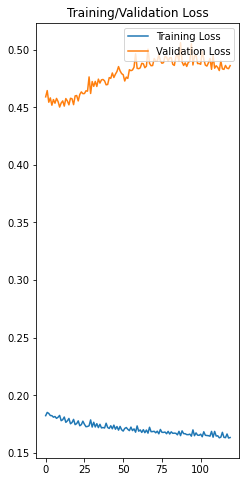

[[-0.31213873]
 [-0.97976879]
 [-0.1734104 ]
 [ 0.33526012]
 [-0.74855491]
 [-0.73699422]
 [ 0.42196532]
 [-0.74277457]]
list_yhat:
[-0.21542674]
1
list_yhat:
[0.2102321]
2
list_yhat:
[-0.7321903]
3
list_yhat:
[-0.6054884]
4
list_yhat:
[0.046179626]
5
list_yhat:
[-0.23575059]
6
list_yhat:
[-0.05750145]
7
list_yhat:
[0.27066785]
8
list_yhat:
[-0.47540098]
9
list_yhat:
[-0.9011234]
10
list_yhat:
[-0.36024374]
11
list_yhat:
[-0.036894552]
12
list_yhat:
[-0.25222263]
13
list_yhat:
[-0.42240754]
14
list_yhat:
[0.056521486]
15
Previsão:[[272.46234]]
Previsão:[[419.7403]]
Previsão:[[93.66215]]
Previsão:[[137.501]]
Previsão:[[362.97815]]
Previsão:[[265.4303]]
Previsão:[[327.1045]]
Previsão:[[440.65106]]
Previsão:[[182.51126]]
Previsão:[[35.211304]]
Previsão:[[222.35567]]
Previsão:[[334.23447]]
Previsão:[[259.731]]
Previsão:[[200.847]]
Previsão:[[366.55643]]
[272.46234, 419.7403, 93.66215, 137.501, 362.97815, 265.4303, 327.1045, 440.65106, 182.51126, 35.211304, 222.35567, 334.23447, 259.731, 20

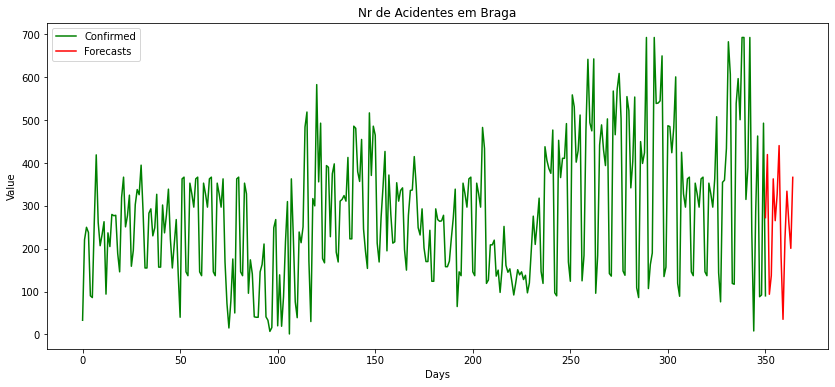

[array([[272.46234]], dtype=float32), array([[419.7403]], dtype=float32), array([[93.66215]], dtype=float32), array([[137.501]], dtype=float32), array([[362.97815]], dtype=float32), array([[265.4303]], dtype=float32), array([[327.1045]], dtype=float32), array([[440.65106]], dtype=float32), array([[182.51126]], dtype=float32), array([[35.211304]], dtype=float32), array([[222.35567]], dtype=float32), array([[334.23447]], dtype=float32), array([[259.731]], dtype=float32), array([[200.847]], dtype=float32), array([[366.55643]], dtype=float32)]
Epoch 1/50
10/10 [==============================] - 1s 24ms/step - loss: 0.4407 - mae: 0.3712 - rmse: 0.4406 - val_loss: 0.5498 - val_mae: 0.5069 - val_rmse: 0.5498
Epoch 2/50
10/10 [==============================] - 0s 7ms/step - loss: 0.2832 - mae: 0.2286 - rmse: 0.2835 - val_loss: 0.3300 - val_mae: 0.2694 - val_rmse: 0.3300
Epoch 3/50
10/10 [==============================] - 0s 8ms/step - loss: 0.2521 - mae: 0.2217 - rmse: 0.2525 - val_loss: 0.341

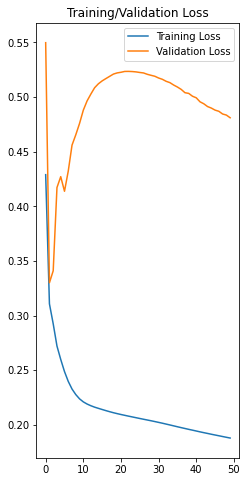

Epoch 1/50
20/20 [==============================] - 0s 6ms/step - loss: 0.3093 - mae: 0.2513 - rmse: 0.3021 - val_loss: 0.2131 - val_mae: 0.1895 - val_rmse: 0.2131
Epoch 2/50
20/20 [==============================] - 0s 4ms/step - loss: 0.2872 - mae: 0.2351 - rmse: 0.2774 - val_loss: 0.2130 - val_mae: 0.1898 - val_rmse: 0.2130
Epoch 3/50
20/20 [==============================] - 0s 4ms/step - loss: 0.2682 - mae: 0.2198 - rmse: 0.2565 - val_loss: 0.2156 - val_mae: 0.1882 - val_rmse: 0.2156
Epoch 4/50
20/20 [==============================] - 0s 3ms/step - loss: 0.2630 - mae: 0.2162 - rmse: 0.2524 - val_loss: 0.2157 - val_mae: 0.1896 - val_rmse: 0.2157
Epoch 5/50
20/20 [==============================] - 0s 3ms/step - loss: 0.2571 - mae: 0.2121 - rmse: 0.2459 - val_loss: 0.2148 - val_mae: 0.1822 - val_rmse: 0.2148
Epoch 6/50
20/20 [==============================] - 0s 4ms/step - loss: 0.2588 - mae: 0.2121 - rmse: 0.2483 - val_loss: 0.2130 - val_mae: 0.1887 - val_rmse: 0.2130
Epoch 7/50
20/20

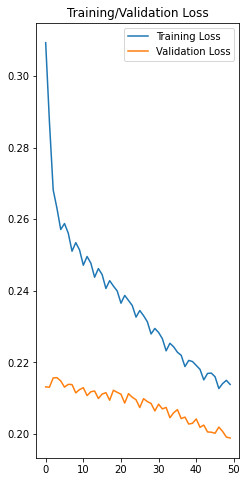

Epoch 1/50
29/29 [==============================] - 0s 4ms/step - loss: 0.2140 - mae: 0.1760 - rmse: 0.2158 - val_loss: 0.3448 - val_mae: 0.2919 - val_rmse: 0.2972
Epoch 2/50
29/29 [==============================] - 0s 3ms/step - loss: 0.2126 - mae: 0.1749 - rmse: 0.2142 - val_loss: 0.3389 - val_mae: 0.2868 - val_rmse: 0.2969
Epoch 3/50
29/29 [==============================] - 0s 3ms/step - loss: 0.2105 - mae: 0.1735 - rmse: 0.2121 - val_loss: 0.3399 - val_mae: 0.2865 - val_rmse: 0.2955
Epoch 4/50
29/29 [==============================] - 0s 3ms/step - loss: 0.2097 - mae: 0.1729 - rmse: 0.2113 - val_loss: 0.3407 - val_mae: 0.2872 - val_rmse: 0.2981
Epoch 5/50
29/29 [==============================] - 0s 3ms/step - loss: 0.2086 - mae: 0.1721 - rmse: 0.2101 - val_loss: 0.3416 - val_mae: 0.2866 - val_rmse: 0.2985
Epoch 6/50
29/29 [==============================] - 0s 3ms/step - loss: 0.2077 - mae: 0.1717 - rmse: 0.2092 - val_loss: 0.3444 - val_mae: 0.2893 - val_rmse: 0.3023
Epoch 7/50
29/29

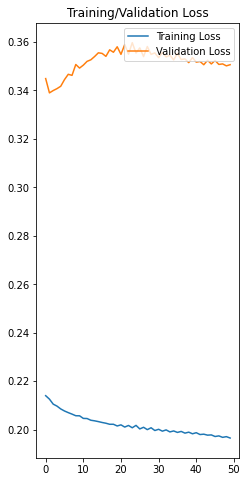

[[ 0.12427746]
 [ 1.        ]
 [-0.31213873]
 [-0.97976879]
 [-0.1734104 ]
 [ 0.33526012]
 [-0.74855491]
 [-0.73699422]
 [ 0.42196532]
 [-0.74277457]]
list_yhat:
[-0.6814989]
1
list_yhat:
[0.07724348]
2
list_yhat:
[0.31010848]
3
list_yhat:
[-0.36901897]
4
list_yhat:
[0.07429286]
5
list_yhat:
[0.14594077]
6
list_yhat:
[-0.39232954]
7
list_yhat:
[-0.48510888]
8
list_yhat:
[-0.052057125]
9
list_yhat:
[0.11216901]
10
list_yhat:
[-0.038243223]
11
list_yhat:
[-0.086675115]
12
list_yhat:
[0.06804427]
13
list_yhat:
[-0.33801413]
14
list_yhat:
[-0.4927535]
15
Previsão:[[111.201385]]
Previsão:[[373.72626]]
Previsão:[[454.29755]]
Previsão:[[219.31943]]
Previsão:[[372.70532]]
Previsão:[[397.49548]]
Previsão:[[211.25398]]
Previsão:[[179.15233]]
Previsão:[[328.98822]]
Previsão:[[385.81046]]
Previsão:[[333.76785]]
Previsão:[[317.0104]]
Previsão:[[370.5433]]
Previsão:[[230.0471]]
Previsão:[[176.50728]]
[111.201385, 373.72626, 454.29755, 219.31943, 372.70532, 397.49548, 211.25398, 179.15233, 328.98822,

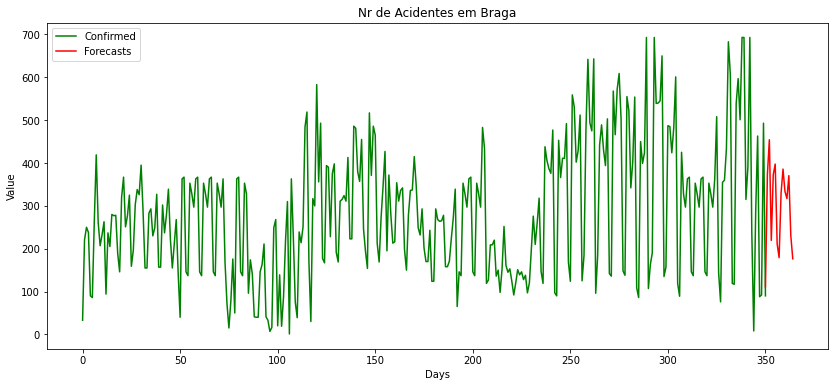

[array([[111.201385]], dtype=float32), array([[373.72626]], dtype=float32), array([[454.29755]], dtype=float32), array([[219.31943]], dtype=float32), array([[372.70532]], dtype=float32), array([[397.49548]], dtype=float32), array([[211.25398]], dtype=float32), array([[179.15233]], dtype=float32), array([[328.98822]], dtype=float32), array([[385.81046]], dtype=float32), array([[333.76785]], dtype=float32), array([[317.0104]], dtype=float32), array([[370.5433]], dtype=float32), array([[230.0471]], dtype=float32), array([[176.50728]], dtype=float32)]
Epoch 1/90
10/10 [==============================] - 1s 21ms/step - loss: 0.3918 - mae: 0.3276 - rmse: 0.3911 - val_loss: 0.6038 - val_mae: 0.5749 - val_rmse: 0.6038
Epoch 2/90
10/10 [==============================] - 0s 7ms/step - loss: 0.2844 - mae: 0.2317 - rmse: 0.2838 - val_loss: 0.4500 - val_mae: 0.4100 - val_rmse: 0.4500
Epoch 3/90
10/10 [==============================] - 0s 6ms/step - loss: 0.2313 - mae: 0.1963 - rmse: 0.2309 - val_los

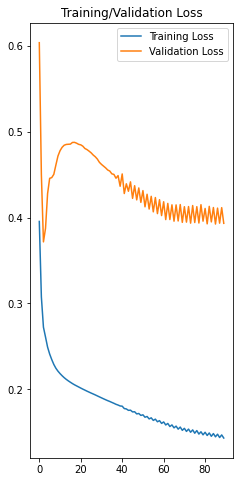

Epoch 1/90
20/20 [==============================] - 0s 5ms/step - loss: 0.2797 - mae: 0.2249 - rmse: 0.2702 - val_loss: 0.1883 - val_mae: 0.1554 - val_rmse: 0.1883
Epoch 2/90
20/20 [==============================] - 0s 4ms/step - loss: 0.2694 - mae: 0.2204 - rmse: 0.2604 - val_loss: 0.1934 - val_mae: 0.1614 - val_rmse: 0.1934
Epoch 3/90
20/20 [==============================] - 0s 4ms/step - loss: 0.2550 - mae: 0.2088 - rmse: 0.2455 - val_loss: 0.1976 - val_mae: 0.1671 - val_rmse: 0.1976
Epoch 4/90
20/20 [==============================] - 0s 4ms/step - loss: 0.2488 - mae: 0.2044 - rmse: 0.2386 - val_loss: 0.2012 - val_mae: 0.1714 - val_rmse: 0.2012
Epoch 5/90
20/20 [==============================] - 0s 4ms/step - loss: 0.2429 - mae: 0.1991 - rmse: 0.2327 - val_loss: 0.1998 - val_mae: 0.1706 - val_rmse: 0.1998
Epoch 6/90
20/20 [==============================] - 0s 4ms/step - loss: 0.2347 - mae: 0.1909 - rmse: 0.2268 - val_loss: 0.1911 - val_mae: 0.1624 - val_rmse: 0.1911
Epoch 7/90
20/20

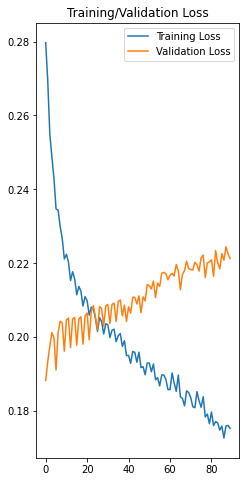

Epoch 1/90
29/29 [==============================] - 0s 4ms/step - loss: 0.1895 - mae: 0.1510 - rmse: 0.1916 - val_loss: 0.3172 - val_mae: 0.2576 - val_rmse: 0.2794
Epoch 2/90
29/29 [==============================] - 0s 4ms/step - loss: 0.1916 - mae: 0.1514 - rmse: 0.1934 - val_loss: 0.3090 - val_mae: 0.2472 - val_rmse: 0.2904
Epoch 3/90
29/29 [==============================] - 0s 3ms/step - loss: 0.1872 - mae: 0.1481 - rmse: 0.1891 - val_loss: 0.3167 - val_mae: 0.2533 - val_rmse: 0.2951
Epoch 4/90
29/29 [==============================] - 0s 3ms/step - loss: 0.1881 - mae: 0.1481 - rmse: 0.1899 - val_loss: 0.3114 - val_mae: 0.2465 - val_rmse: 0.2991
Epoch 5/90
29/29 [==============================] - 0s 3ms/step - loss: 0.1870 - mae: 0.1477 - rmse: 0.1888 - val_loss: 0.3168 - val_mae: 0.2501 - val_rmse: 0.3032
Epoch 6/90
29/29 [==============================] - 0s 3ms/step - loss: 0.1869 - mae: 0.1473 - rmse: 0.1886 - val_loss: 0.3115 - val_mae: 0.2447 - val_rmse: 0.3016
Epoch 7/90
29/29

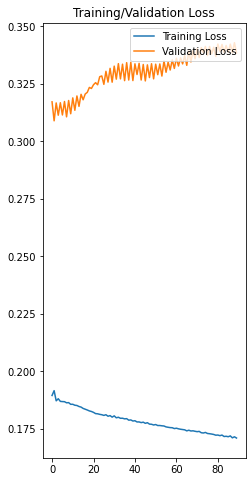

[[ 0.12427746]
 [ 1.        ]
 [-0.31213873]
 [-0.97976879]
 [-0.1734104 ]
 [ 0.33526012]
 [-0.74855491]
 [-0.73699422]
 [ 0.42196532]
 [-0.74277457]]
list_yhat:
[0.08038269]
1
list_yhat:
[-0.46682128]
2
list_yhat:
[-0.46946284]
3
list_yhat:
[-0.70811605]
4
list_yhat:
[-0.30862597]
5
list_yhat:
[0.06839563]
6
list_yhat:
[0.27440616]
7
list_yhat:
[-0.06332054]
8
list_yhat:
[0.04515734]
9
list_yhat:
[-0.400804]
10
list_yhat:
[-0.7851102]
11
list_yhat:
[-0.22373508]
12
list_yhat:
[-0.089865394]
13
list_yhat:
[-0.35866266]
14
list_yhat:
[-0.061144993]
15
Previsão:[[374.8124]]
Previsão:[[185.47984]]
Previsão:[[184.56587]]
Previsão:[[101.991844]]
Previsão:[[240.21542]]
Previsão:[[370.66492]]
Previsão:[[441.94452]]
Previsão:[[325.0911]]
Previsão:[[362.62445]]
Previsão:[[208.32182]]
Previsão:[[75.351875]]
Previsão:[[269.58765]]
Previsão:[[315.9066]]
Previsão:[[222.90271]]
Previsão:[[325.8438]]
[374.8124, 185.47984, 184.56587, 101.991844, 240.21542, 370.66492, 441.94452, 325.0911, 362.62445, 20

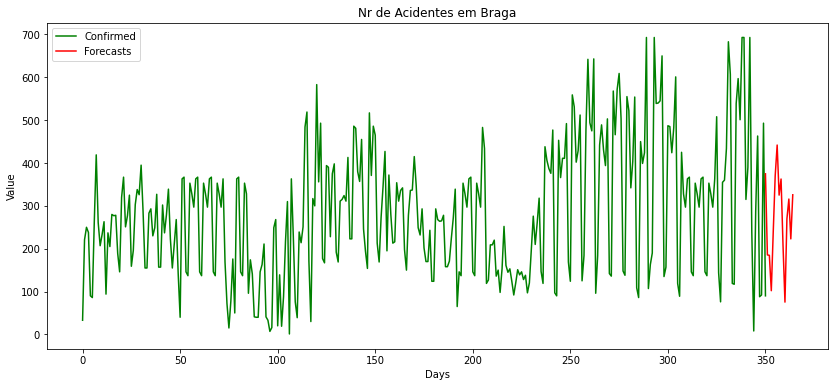

[array([[374.8124]], dtype=float32), array([[185.47984]], dtype=float32), array([[184.56587]], dtype=float32), array([[101.991844]], dtype=float32), array([[240.21542]], dtype=float32), array([[370.66492]], dtype=float32), array([[441.94452]], dtype=float32), array([[325.0911]], dtype=float32), array([[362.62445]], dtype=float32), array([[208.32182]], dtype=float32), array([[75.351875]], dtype=float32), array([[269.58765]], dtype=float32), array([[315.9066]], dtype=float32), array([[222.90271]], dtype=float32), array([[325.8438]], dtype=float32)]
Epoch 1/120
10/10 [==============================] - 1s 21ms/step - loss: 0.4295 - mae: 0.3490 - rmse: 0.4297 - val_loss: 0.6306 - val_mae: 0.5832 - val_rmse: 0.6306
Epoch 2/120
10/10 [==============================] - 0s 7ms/step - loss: 0.3064 - mae: 0.2404 - rmse: 0.3068 - val_loss: 0.4498 - val_mae: 0.3802 - val_rmse: 0.4498
Epoch 3/120
10/10 [==============================] - 0s 6ms/step - loss: 0.2630 - mae: 0.2233 - rmse: 0.2636 - val_l

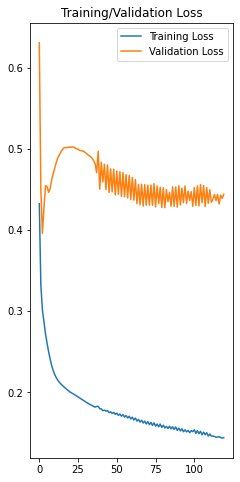

Epoch 1/120
20/20 [==============================] - 0s 6ms/step - loss: 0.2739 - mae: 0.2130 - rmse: 0.2722 - val_loss: 0.1944 - val_mae: 0.1625 - val_rmse: 0.1944
Epoch 2/120
20/20 [==============================] - 0s 4ms/step - loss: 0.2592 - mae: 0.2069 - rmse: 0.2542 - val_loss: 0.1893 - val_mae: 0.1530 - val_rmse: 0.1893
Epoch 3/120
20/20 [==============================] - 0s 4ms/step - loss: 0.2455 - mae: 0.1980 - rmse: 0.2391 - val_loss: 0.1913 - val_mae: 0.1556 - val_rmse: 0.1913
Epoch 4/120
20/20 [==============================] - 0s 4ms/step - loss: 0.2387 - mae: 0.1947 - rmse: 0.2308 - val_loss: 0.1926 - val_mae: 0.1558 - val_rmse: 0.1926
Epoch 5/120
20/20 [==============================] - 0s 4ms/step - loss: 0.2328 - mae: 0.1908 - rmse: 0.2238 - val_loss: 0.1950 - val_mae: 0.1580 - val_rmse: 0.1950
Epoch 6/120
20/20 [==============================] - 0s 4ms/step - loss: 0.2293 - mae: 0.1877 - rmse: 0.2196 - val_loss: 0.1961 - val_mae: 0.1586 - val_rmse: 0.1961
Epoch 7/12

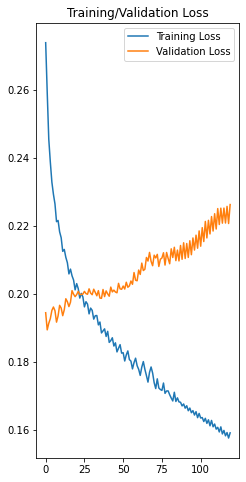

Epoch 1/120
29/29 [==============================] - 0s 4ms/step - loss: 0.1764 - mae: 0.1422 - rmse: 0.1784 - val_loss: 0.3642 - val_mae: 0.2864 - val_rmse: 0.3641
Epoch 2/120
29/29 [==============================] - 0s 3ms/step - loss: 0.1774 - mae: 0.1415 - rmse: 0.1791 - val_loss: 0.3415 - val_mae: 0.2729 - val_rmse: 0.3535
Epoch 3/120
29/29 [==============================] - 0s 3ms/step - loss: 0.1749 - mae: 0.1403 - rmse: 0.1765 - val_loss: 0.3476 - val_mae: 0.2758 - val_rmse: 0.3499
Epoch 4/120
29/29 [==============================] - 0s 3ms/step - loss: 0.1751 - mae: 0.1394 - rmse: 0.1767 - val_loss: 0.3382 - val_mae: 0.2706 - val_rmse: 0.3463
Epoch 5/120
29/29 [==============================] - 0s 3ms/step - loss: 0.1742 - mae: 0.1392 - rmse: 0.1758 - val_loss: 0.3401 - val_mae: 0.2722 - val_rmse: 0.3449
Epoch 6/120
29/29 [==============================] - 0s 3ms/step - loss: 0.1739 - mae: 0.1385 - rmse: 0.1755 - val_loss: 0.3353 - val_mae: 0.2692 - val_rmse: 0.3431
Epoch 7/12

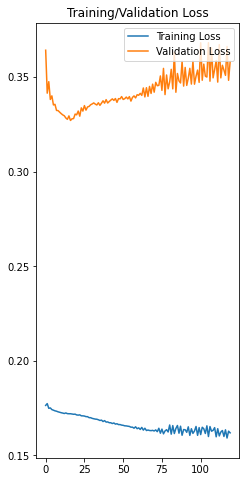

[[ 0.12427746]
 [ 1.        ]
 [-0.31213873]
 [-0.97976879]
 [-0.1734104 ]
 [ 0.33526012]
 [-0.74855491]
 [-0.73699422]
 [ 0.42196532]
 [-0.74277457]]
list_yhat:
[-0.052813437]
1
list_yhat:
[0.2199536]
2
list_yhat:
[-0.21083537]
3
list_yhat:
[-0.102244884]
4
list_yhat:
[0.11504508]
5
list_yhat:
[0.11276502]
6
list_yhat:
[-0.1740421]
7
list_yhat:
[-0.072825655]
8
list_yhat:
[0.31953034]
9
list_yhat:
[-0.13226664]
10
list_yhat:
[-0.0122051295]
11
list_yhat:
[0.036179684]
12
list_yhat:
[0.30612323]
13
list_yhat:
[0.18892637]
14
list_yhat:
[0.06819841]
15
Previsão:[[328.72656]]
Previsão:[[423.10394]]
Previsão:[[274.05096]]
Previsão:[[311.6233]]
Previsão:[[386.8056]]
Previsão:[[386.0167]]
Previsão:[[286.78143]]
Previsão:[[321.8023]]
Previsão:[[457.5575]]
Previsão:[[301.23575]]
Previsão:[[342.77704]]
Previsão:[[359.5182]]
Previsão:[[452.91864]]
Previsão:[[412.36853]]
Previsão:[[370.59665]]
[328.72656, 423.10394, 274.05096, 311.6233, 386.8056, 386.0167, 286.78143, 321.8023, 457.5575, 301.2357

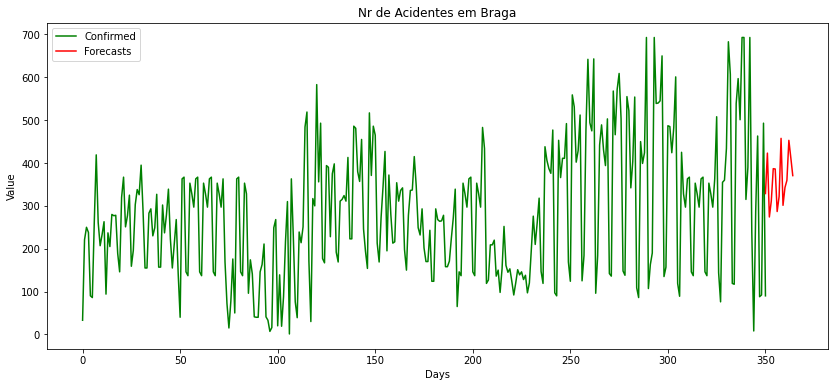

[array([[328.72656]], dtype=float32), array([[423.10394]], dtype=float32), array([[274.05096]], dtype=float32), array([[311.6233]], dtype=float32), array([[386.8056]], dtype=float32), array([[386.0167]], dtype=float32), array([[286.78143]], dtype=float32), array([[321.8023]], dtype=float32), array([[457.5575]], dtype=float32), array([[301.23575]], dtype=float32), array([[342.77704]], dtype=float32), array([[359.5182]], dtype=float32), array([[452.91864]], dtype=float32), array([[412.36853]], dtype=float32), array([[370.59665]], dtype=float32)]


In [15]:
################################
################################
########                ########
######## Main Execution ########
########                ########
################################
################################

n_variate = 4 #1, 2, 3  # number of features used by the model (using conf. cases to predict conf. cases) 

#the dataframes

df_raw = load_dataset('dataset_test_v3.csv')
df_data = prepare_data(df_raw)
df = df_data.copy()
n_variate = len(df.columns)
plot_confirmed_cases(df_data) #the plot you saw previously
scaler = data_normalization(df) #scaling data to [-1,1]


##Optimization

tunning_dict = {
                  1: {'timesteps' : 7, 'multisteps' : 15, 'cv_splits': 3, 'epochs' : 10,  'batch_size' : 5 },
                  2: {'timesteps' : 7, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 50,  'batch_size' : 5 },
                  3: {'timesteps' : 7, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 100,  'batch_size' : 5 },

                  
                  4: {'timesteps' : 8, 'multisteps' : 15, 'cv_splits': 3, 'epochs' : 60,  'batch_size' : 5 },
                  5: {'timesteps' : 8, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 5 },
                  6: {'timesteps' : 8, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 5 },
                  
                  7: {'timesteps' : 10, 'multisteps' : 15, 'cv_splits': 3, 'epochs' : 50,  'batch_size' : 8 },
                  8: {'timesteps' : 10, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 90,  'batch_size' : 8 },
                  9: {'timesteps' : 10, 'multisteps' : 15, 'cv_splits' : 3, 'epochs' : 120,  'batch_size' : 8 }

  }
  # record da history de cada modelo
record = {}

#tunning the model cycle
for t in tunning_dict:
   # print(record[r])
   # fitting the model
   timesteps = tunning_dict[t]['timesteps']
   epochs = tunning_dict[t]['epochs']
   batch_size = tunning_dict[t]['batch_size']
   multisteps = tunning_dict[t]['multisteps']
   cv_splits = tunning_dict[t]['cv_splits']
   # print(timesteps,epochs,batch_size,cv_splits)

   X, y = to_supervised(df, timesteps)

   model = build_model(timesteps, n_variate)
   model, history = compile_and_fit(model, epochs, batch_size)
   # print("df: ",df.shape," timesteps",timesteps," multisteps ",multisteps)
   forecasts = forecast(model, df, timesteps, multisteps, scaler)
   plot_forecast(df_data, forecasts)
   print(forecasts)

   prev = []

   record[t] = history


  #Put the resulting metrics in a file
id_tunning = 1
id_split = 1

final_dict = {}

for r in record:
    # print(tunning_dict[1]['epochs'])
    loss = []
    mae = []
    rmse = []
    val_loss = []
    val_mae = []
    val_rmse = []

    for h in record[r]:
      # print("Tunning ID:  ",id_tunning," Split ID: ",id_split)
      # plot_learning_curves(h, tunning_dict[id_tunning]['epochs'])
      # ['loss', 'mae', 'rmse', 'val_loss', 'val_mae', 'val_rmse']
      # print("loss: ",sum(h.history['loss'])/len(h.history['loss'])," MAE: ",sum(h.history['mae'])/len(h.history['mae'])," RMSE: ",sum(h.history['rmse'])/len(h.history['rmse'])," VAL_LOSS: ",sum(h.history['val_loss'])/len(h.history['val_loss'])," VAL_MAE: ",sum(h.history['val_mae'])/len(h.history['val_mae'])," VAL_RMSE: ",sum(h.history['val_rmse'])/len(h.history['val_rmse']))
      loss.append(sum(h.history['loss']) / len(h.history['loss']))
      mae.append(sum(h.history['mae']) / len(h.history['mae']))
      rmse.append(sum(h.history['rmse']) / len(h.history['rmse']))
      val_loss.append(sum(h.history['val_loss']) / len(h.history['val_loss']))
      val_mae.append(sum(h.history['val_mae']) / len(h.history['val_mae']))
      val_rmse.append(sum(h.history['val_rmse']) / len(h.history['val_rmse']))
      id_split += 1
    id_split = 1

    final_dict[id_tunning] = [sum(loss) / len(loss), sum(mae) / len(mae), sum(rmse) / len(rmse),
                              sum(val_loss) / len(val_loss), sum(val_mae) / len(val_mae), sum(val_rmse) / len(val_rmse)]

    id_tunning = id_tunning + 1




In [16]:
for f in final_dict:
    print("Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE")
    print("ID tunning: ",f, " Valores: ",final_dict[f],"\n")

final_df = pd.DataFrame.from_dict(final_dict, orient='index')
final_df.columns = ['Loss','MAE','RMSE','VAL_LOSS','VAL_MAE','VAL_RMSE']
final_df

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  1  Valores:  [0.24324212620655694, 0.2064963608980179, 0.244634352127711, 0.3464094956715902, 0.3122083455324173, 0.34525421112775806] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  2  Valores:  [0.21516135603189468, 0.17852217892805733, 0.21624719033638637, 0.3148791532715161, 0.2682930820186933, 0.3127242066462834] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  3  Valores:  [0.19850683828194934, 0.1664389681319396, 0.19952927206953366, 0.32780054584145546, 0.28540799806515377, 0.3225450542072455] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  4  Valores:  [0.20216602865192623, 0.17132025948829122, 0.20095501467585564, 0.32387683747543233, 0.2834888166023625, 0.31716445709268254] 

Loss | MAE | RMSE | VAL_LOSS | VAL_MAE | VAL_RMSE
ID tunning:  5  Valores:  [0.1888010651425079, 0.15831780218415792, 0.18702053311798308, 0.3098384882564898, 0.2603315812570078, 0.3103091969

,Loss,MAE,RMSE,VAL_LOSS,VAL_MAE,VAL_RMSE
1,0.243242,0.206496,0.244634,0.346409,0.312208,0.345254
2,0.215161,0.178522,0.216247,0.314879,0.268293,0.312724
3,0.198507,0.166439,0.199529,0.327801,0.285408,0.322545
4,0.202166,0.171320,0.200955,0.323877,0.283489,0.317164
5,0.188801,0.158318,0.187021,0.309838,0.260332,0.310309
6,0.170361,0.142968,0.168752,0.366719,0.306882,0.361026
7,0.218435,0.181033,0.214824,0.350818,0.296121,0.344388
8,0.186819,0.151435,0.182657,0.325595,0.266198,0.310477
9,0.176463,0.142941,0.172599,0.336458,0.278973,0.348351
